<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafio 4: Predicción de próxima palabra

### Objetivo
El objetivo de este desafio es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. 

Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

### Generamos el dataset para su posterior procesamiento

#### Importamos las librerias necesarias


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.text import text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences 
from keras.layers import Bidirectional

In [2]:
#Si se utiliza google drive en colab
#from google.colab import drive
#drive.mount('/content/drive')

#### Cargamos el dataset para su poesterior procesamiento

Utilizaremos como dataset el libro del hobbit, que se encuentra en formato txt

In [3]:
file = open("TheHobbit.txt", mode="rt", encoding='windows-1251')
libro=file.read()
file.close()

Mostramos la variable libro para ver si se cargo bien el texto

In [4]:
libro

'                                               Chapter I \n\n                                        An Unexpected Party \n\n     In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort. \n\n     It   had   a  perfectly   round   door   like   a   porthole,   painted   green,   with   a   shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors. The tunnel wound on and on, going  fairly  but  not  quite  straight  into  the  side  of  the  hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of \n\nit,

#### Separamos el texto según los párrafos y quitamos párrafos vacios

In [5]:
lista_articulos = libro.split("\n")
lista_articulos = list(filter(None, lista_articulos))
lista_articulos

['                                               Chapter I ',
 '                                        An Unexpected Party ',
 '     In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort. ',
 '     It   had   a  perfectly   round   door   like   a   porthole,   painted   green,   with   a   shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors. The tunnel wound on and on, going  fairly  but  not  quite  straight  into  the  side  of  the  hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of ',


#### Armamos el dataset a partir de la lista de articulos

In [6]:
df  = pd.DataFrame(lista_articulos)
df.head()

,0
0,...
1,An Une...
2,In a hole in the ground there lived a hob...
3,It had a perfectly round door ...
4,"it, first on one side and then on ..."


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1907


### 1 - Realizamos el preprocesamiento

Realizar el preprocesamiento implica:

- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

#### Definimos el largo de nuestra secuencia 

In [8]:
# largo de la secuencia, incluye seq input + word output
train_len = 4

#### Armamos el corpus

In [9]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
#Quito los espacios repetidos, que hay muchos en el texto
corpus = re.sub(r'\s+', ' ', corpus)
corpus

' Chapter I An Unexpected Party In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort. It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors. The tunnel wound on and on, going fairly but not quite straight into the side of the hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of it, first on one side and then on another. No going upstairs for the hobbit: bedrooms, bathrooms, cellars, pantries (lots of these), wardrobes (he had 

#### Transformamos el corpus a tokens

In [10]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)

In [11]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 96238


In [12]:
print("Primeros tokens del corpus: ")
tokens[:10]

Primeros tokens del corpus: 


['chapter', 'i', 'an', 'unexpected', 'party', 'in', 'a', 'hole', 'in', 'the']

#### Transformamos las oraciones en secuencias (tokens) de palabras segun la longitud definida

In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)


In [14]:
print("Primeros vectores  de texto generados: \n")
text_sequences[:10]  

Primeros vectores  de texto generados: 



[['chapter', 'i', 'an', 'unexpected'],
 ['i', 'an', 'unexpected', 'party'],
 ['an', 'unexpected', 'party', 'in'],
 ['unexpected', 'party', 'in', 'a'],
 ['party', 'in', 'a', 'hole'],
 ['in', 'a', 'hole', 'in'],
 ['a', 'hole', 'in', 'the'],
 ['hole', 'in', 'the', 'ground'],
 ['in', 'the', 'ground', 'there'],
 ['the', 'ground', 'there', 'lived']]

#### Convertimos las secuencias de texto a secuencia de números



In [15]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
print("Primeros vectores de numeros generados: \n")
sequences[:10]

Primeros vectores de numeros generados: 



[[591, 15, 113, 1037],
 [15, 113, 1037, 719],
 [113, 1037, 719, 7],
 [1037, 719, 7, 5],
 [719, 7, 5, 290],
 [7, 5, 290, 7],
 [5, 290, 7, 1],
 [290, 7, 1, 293],
 [7, 1, 293, 27],
 [1, 293, 27, 442]]

In [17]:
print("Cantidad de secuencias generadas:", len(sequences))

Cantidad de secuencias generadas: 96234


In [18]:
# Vemos el index_word del tokenizador, que esta ordenado por las palabras más populares a menos populares
tok.index_word

{1: 'the',
 2: 'and',
 3: 'of',
 4: 'to',
 5: 'a',
 6: 'he',
 7: 'in',
 8: 'was',
 9: 'they',
 10: 'it',
 11: 'that',
 12: 'had',
 13: 'his',
 14: 'you',
 15: 'i',
 16: 'on',
 17: 'not',
 18: 'for',
 19: 'were',
 20: 'as',
 21: 'at',
 22: 'all',
 23: 'but',
 24: 'with',
 25: 'said',
 26: 'them',
 27: 'there',
 28: 'their',
 29: 'bilbo',
 30: 'is',
 31: 'him',
 32: 'have',
 33: 'from',
 34: 'could',
 35: 'out',
 36: 'be',
 37: 'up',
 38: 'or',
 39: 'we',
 40: 'if',
 41: 'down',
 42: 'are',
 43: 'no',
 44: 'now',
 45: 'so',
 46: 'one',
 47: 'by',
 48: 'what',
 49: 'dwarves',
 50: 'this',
 51: 'when',
 52: 'then',
 53: 'very',
 54: 'came',
 55: 'would',
 56: 'into',
 57: 'more',
 58: 'before',
 59: 'thorin',
 60: 'like',
 61: 'long',
 62: 'time',
 63: 'back',
 64: 'about',
 65: 'come',
 66: 'been',
 67: 'your',
 68: 'some',
 69: 'will',
 70: 'great',
 71: 'did',
 72: 'again',
 73: 'good',
 74: 'after',
 75: 'still',
 76: 'my',
 77: 'gandalf',
 78: 'which',
 79: 'far',
 80: 'only',
 81: 'g

### 2 - Generamos los vectores de input y target

A partir de las secuencias generadas, armamos los vectores de input y target para entrenar nuestra red

- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

#### Separamos las secuencias en vectores x_data e y_data

In [19]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] 

print("Shape del vector x_data:" ,x_data.shape)
print("Shape del vector y_data_int:" ,y_data_int.shape)

Shape del vector x_data: (96234, 3)
Shape del vector y_data_int: (96234,)


#### Hacemos el oneHotEncoding del vector de y_data

In [20]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6283

In [21]:
# Transformar los datos a oneHotEncoding
y_data_int_offset = y_data_int - 1 # Restamos 1 en el y_data_int para que comience en 0 y no en 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
print("Shape de y_data: ",y_data.shape)


Shape de y_data:  (96234, 6283)


### 3 - Entrenamos el modelo dos arquitecturas de red

#### Calculamos dimensiones de entrada y salida de la red

In [22]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [23]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6283

#### Generamos nuestro primer modelo

In [28]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 6283 palabras distintas
output_dim = 10 #--> tamaño del embeding a generar
model.add(Embedding(input_dim=vocab_size+1, output_dim=output_dim, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 6283 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             62840     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             19200     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 6283)              2

#### Entrenamos el modelo y vemos la accuracy del mismo

In [29]:
epochs = 500
hist = model.fit(x_data, y_data, epochs=epochs, validation_split=0.3)

Epoch 1/500
2106/2106 [==============================] - 35s 12ms/step - loss: 6.4633 - accuracy: 0.0612 - val_loss: 6.4824 - val_accuracy: 0.0683
Epoch 2/500
2106/2106 [==============================] - 23s 11ms/step - loss: 6.1149 - accuracy: 0.0706 - val_loss: 6.4023 - val_accuracy: 0.0807
Epoch 3/500
2106/2106 [==============================] - 23s 11ms/step - loss: 5.8753 - accuracy: 0.0815 - val_loss: 6.3592 - val_accuracy: 0.0912
Epoch 4/500
2106/2106 [==============================] - 24s 11ms/step - loss: 5.6681 - accuracy: 0.0978 - val_loss: 6.3326 - val_accuracy: 0.1040
Epoch 5/500
2106/2106 [==============================] - 23s 11ms/step - loss: 5.4953 - accuracy: 0.1126 - val_loss: 6.3921 - val_accuracy: 0.1084
Epoch 6/500
2106/2106 [==============================] - 23s 11ms/step - loss: 5.3643 - accuracy: 0.1191 - val_loss: 6.4992 - val_accuracy: 0.1114
Epoch 7/500
2106/2106 [==============================] - 23s 11ms/step - loss: 5.2495 - accuracy: 0.1254 - val_loss: 6

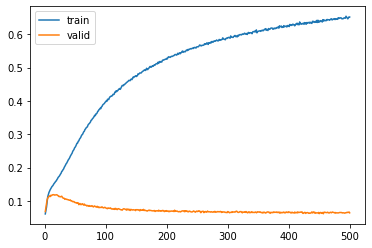

In [31]:
# Graficamos accuracy en train y validacion
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

#### Generamos un segundo modelo

In [24]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 6283 palabras distintas
output_dim = 10 #--> tamaño del embeding a generar
model2.add(Embedding(input_dim=vocab_size+1, output_dim=output_dim, input_length=input_seq_len))

model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.15))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 6283 palabras posibles
model2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             62840     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           38400     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 6283)              2

#### Entrenamos el segundo modelo y vemos la accuracy del mismo

In [25]:
epochs = 500
hist2 = model2.fit(x_data, y_data, epochs=epochs, validation_split=0.3)

Epoch 1/500
2106/2106 [==============================] - 70s 29ms/step - loss: 6.3962 - accuracy: 0.0611 - val_loss: 6.3699 - val_accuracy: 0.0712
Epoch 2/500
2106/2106 [==============================] - 56s 27ms/step - loss: 5.9636 - accuracy: 0.0753 - val_loss: 6.2513 - val_accuracy: 0.0880
Epoch 3/500
2106/2106 [==============================] - 56s 27ms/step - loss: 5.7028 - accuracy: 0.0949 - val_loss: 6.2679 - val_accuracy: 0.1046
Epoch 4/500
2106/2106 [==============================] - 56s 26ms/step - loss: 5.5205 - accuracy: 0.1159 - val_loss: 6.3103 - val_accuracy: 0.1126
Epoch 5/500
2106/2106 [==============================] - 56s 27ms/step - loss: 5.3722 - accuracy: 0.1256 - val_loss: 6.3656 - val_accuracy: 0.1169
Epoch 6/500
2106/2106 [==============================] - 56s 27ms/step - loss: 5.2530 - accuracy: 0.1326 - val_loss: 6.4519 - val_accuracy: 0.1187
Epoch 7/500
2106/2106 [==============================] - 56s 26ms/step - loss: 5.1476 - accuracy: 0.1383 - val_loss: 6

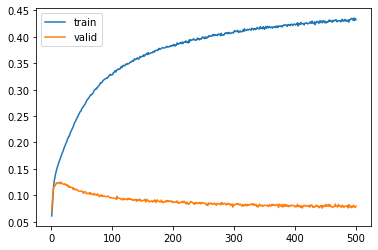

In [26]:
# Graficamos accuracy en train y validacion
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

### 4 - Predicción de próxima palabra

#### Generamos algunos ejemplos para probar la prediccion de nuestros 2 modelos a mano

In [27]:
def calculo_proxima(texto,modelo):

    # Encodeamos
    encoded = tok.texts_to_sequences([texto])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = modelo.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return texto + ' ' + out_word

In [34]:
text_test = "Bilbo kill the"
prediccion_modelo1 = calculo_proxima(text_test,model)
print("Prediccion modelo 1: ",prediccion_modelo1)



Prediccion modelo 1:  Bilbo kill the flowed


In [28]:
text_test = "Bilbo kill the"
prediccion_modelo2 = calculo_proxima(text_test,model2)
print("Prediccion modelo 2: ",prediccion_modelo2)

Prediccion modelo 2:  Bilbo kill the grandfather


#### Utilizamos la libreria de gradio para hacer un ensayo a traves de la UI que nos brinda

In [ ]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

### 5 - Probamos la generación de secuencias nuevas

#### Generamos nuestra funcion de prediccion de proximas palabras

In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

#### Hacemos un par de pruebas con los 2 modelos entrenados

In [36]:
input_text='Bilbo kill the'
max_length = 3
n_words = 2

seq_modelo1 = generate_seq(model, tok, input_text, max_length=max_length, n_words=n_words)
print("Secuencia con el modelo 1: ",seq_modelo1)

Secuencia con el modelo 1:  Bilbo kill the flowed before


In [30]:
input_text='Bilbo kill the'
max_length = 3
n_words = 2

seq_modelo2 = generate_seq(model2, tok, input_text, max_length=max_length, n_words=n_words)
print("Secuencia con el modelo 2: ",seq_modelo2)

Secuencia con el modelo 2:  Bilbo kill the grandfather wait


In [32]:
def prueba_modelo(input_text):
  seq_modelo = generate_seq(model2, tok, input_text, max_length=max_length, n_words=n_words)
  print("Prueba de secuencia: ",seq_modelo)

In [37]:
prueba_modelo('The hobbnit is')
prueba_modelo('Smaug was killed')
prueba_modelo('Smaug is a')
prueba_modelo('gold and silver')


Prueba de secuencia:  The hobbnit is guarded a
Prueba de secuencia:  Smaug was killed a again
Prueba de secuencia:  Smaug is a roasting belongs
Prueba de secuencia:  gold and silver certain was


### 6 - Conclusiones

Se pudieron entrenar 2 modelos con 2 configuraciones diferentes, una con solo capas LSTM y otro con LSTM+capa bidireccional.

Si bien el dataset no es muy extenso, el mismo contaba con 96238 tokens y 6283 palabras.

El tiempo de entrenamiento fue muy alto, de unas 3 horas por modelo, teniendo en cuenta que se utilizaron 500 epochs y los modelos tenían 500 y 800 mil parámetros en total.

Los resultados de los 2 modelos para la prediccion no fueron muy buenos. Las palabras predichas no siempre tienen sentido. Esto se ve más claramente en el punto 5 donde queremos generar nuevas secuencias y las frases generadas no siempre tienen concordancia sintáctica o semántica. Quizás habría que hacer un preprocesamiento mayor o quitar stop word o palabras muy comunes para mejorar la predicción de próxima palabra.